### Observations of Snow from space - snow phenology

##### What does this notebook do?
Plotting snow phenology, investigating patterns in the seasonal/cyclic nature of snow in the NSW Alpine region.
<br>
In this notebook:
<br>
identify snow over a given region - ndsi/ndvi (/ndwi?) - pixels defined as snow/not snow
import a dem, and mask for pixels over a given elevation
for pixels over this elevation - number of pixels classified as snow v. number of valid pixels - plotted against "day of the year"
Compare 2 differen elevations
Compare these two elevations over a decade? compare these by decade - means plotted on same figure.

Snow mask tool - ACCA and fmask - two different snow masks, both at times falsely classify snow as cloud (and is masked out) - tool indicates which maske might perform better for a given region/time range.


In [1]:
import sys
import warnings
import datacube
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff
import os

sys.path.append('../10_Scripts')
import SpatialTools
import gdal
import DEADataHandling
import DEAPlotting

In [2]:
# Connect to datacube database
dc = datacube.Datacube(app='Snow monitoring with Landsat')


output='results/nsw/notebook/'

In [22]:
# lat, lon, buffer_m, buffer_n = -36.86895, 147.276, 30000, 30000 #vic
# lat, lon, buffer_m, buffer_n = -41.56728, 147.67106, 10000, 10000 #tas ben lomond
lat, lon, buffer_m, buffer_n = -36.48, 148.26, 10000, 10000 #nsw
time_range10s = ('2019-01-01', '2019-08-31')

resolution = (-25, 25)

landsat_goodquality_prop = 0.3

# working out thresholds - geotiff for a number of different ones (methods for verification etc)
# fine tuned for different elevations.. 
#- trees change at different altidudes etc.. (depeding on region accurate thesholds can vary usually btwn 0.0-0.5)
ndsi_threshold = 0.2
ndvi_threshold = 0.3
ndwi_threshold = 0.15
red_threshold = 1000

In [23]:
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query10s = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range10s,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}


In [5]:
DEAPlotting.display_map(y=query10s['y'], x=query10s['x'])

In [24]:
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, product = 'nbar', query=query10s, sensors=['ls8', 'ls7','ls5'], 
                                               bands_of_interest=['red', 'green', 'blue'], masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False, ls7_slc_off=False)

Loading ls8
    Loading 19 filtered ls8 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls5
    Skipping ls5; no valid data for query
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


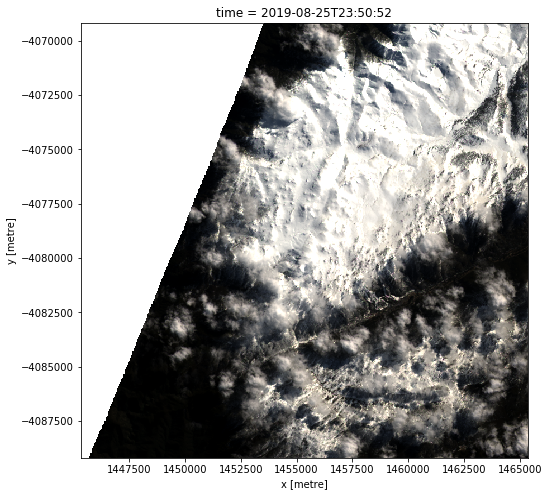

In [25]:
landsat_ds[['red', 'green', 'blue']].isel(time=18).to_array().plot.imshow(robust=True, figsize=(8,8))

Cloud mask - both ACCA and fmask can at times falsely classify snow as cloud (at the end of this notebook is a tool for selecting the mask that will minimize the number of fasely classified pixels for a given region/time range)

In [28]:
snow_mask = dict(    #cloud_acca='no_cloud',
                     cloud_fmask='no_cloud',
                     #cloud_shadow_acca='no_cloud_shadow',
                     cloud_shadow_fmask='no_cloud_shadow',
                     blue_saturated=False,
                     green_saturated=False,
                     red_saturated=False,
                     nir_saturated=False,
                     swir1_saturated=False,
                     swir2_saturated=False,
                     contiguous=True)

landsat_ds10s = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query10s,
                                               mask_dict=snow_mask,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=False)

Loading ls8
    Loading 126 filtered ls8 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls5
    Loading 23 filtered ls5 timesteps
Combining and sorting ls8, ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [29]:
valid_ds10s = np.isfinite(landsat_ds10s.swir1)

In [30]:
ndsi_ds10s = (landsat_ds10s.green - landsat_ds10s.swir1) / (landsat_ds10s.green + landsat_ds10s.swir1)
ndvi_ds10s = (landsat_ds10s.nir - landsat_ds10s.red) / (landsat_ds10s.nir + landsat_ds10s.red)

In [31]:
snow_ds1 = ndsi_ds10s > ndsi_threshold
noveg_ds10s = ndvi_ds10s < ndvi_threshold
red_ds10s = landsat_ds10s.red > 1000
snow_ds10s = noveg_ds10s & snow_ds1 & red_ds10s

Plot of snow/no-snow for given region - include true colour image

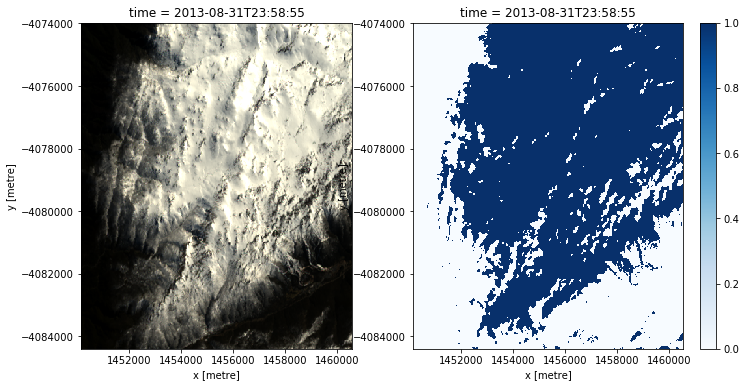

In [32]:
fig, axes = plt.subplots(ncols=2, figsize = (12, 6), gridspec_kw={'width_ratios': [4, 5]})
landsat_ds[['red', 'green', 'blue']].isel(time=28).to_array().plot.imshow(robust=True, ax=axes[0])
snow_ds10s.isel(time=31).plot(cmap='Blues', ax=axes[1])


Importing DEM - looking at snow pixels specifically above a given elevation

In [26]:
# define the elevation to be investigated - 2 defined here
elev = 1800
elev1= 1500

In [27]:
# Importing dem
# query region identical to the region being investigated, minus the time range
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query_dem = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

# Load the DEM data
dem_ds = dc.load(product='srtm_dem1sv1_0', **query_dem)
dem_elev = dem_ds.dem > elev
dem_elev1 = dem_ds.dem > elev1

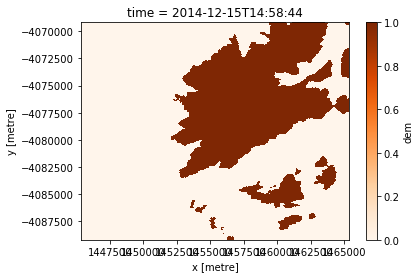

In [28]:
dem_elev.plot(cmap='Oranges')

Creating DEM contours

In [43]:
elevation_2d = dem_ds.dem_h.squeeze('time')
contour_gdf_1800 = SpatialTools.contour_extract(z_values=1800,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_contours_1800.shp')


Operating in single array, multiple z-values mode
    Extracting contour 1800
Exporting contour shapefile to extracted_contours_1800.shp


plot the contours around for the region (same plot)
number of pixels over this level - can give an indication of the snow level/elevation

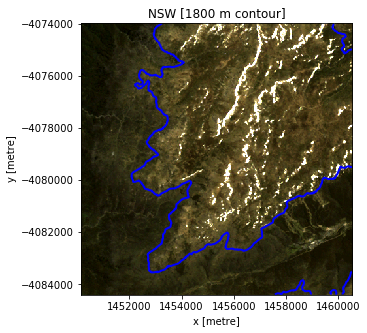

In [44]:
fig, ax = plt.subplots(figsize=(6, 5))
a=landsat_ds[['red', 'green', 'blue']].isel(time=20).to_array().plot.imshow(robust=True, ax=ax)
a=contour_gdf_1800.plot(linewidth=2, color='blue', ax=ax)
# a=contour_gdf_1500.plot(linewidth=2, color='firebrick', ax=ax)
a.title.set_text('NSW [1800 m contour]')

Snow phenology
This calculates:
For pixels above the given elevation, number of pixels identified as snow / number of valid pixels

In [46]:
c=list(range(len(snow_ds10s.time)))
snow_prop_elev10s=[]
for i in c:
    d = valid_ds10s.isel(time=i).values * dem_elev
    f = snow_ds10s.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev10s.append(snow)

In [47]:
snow_df10s = pd.DataFrame({'dayofyear':snow_ds10s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev10s, 'year':snow_ds10s['time.year']})

In [48]:
landsat_ds

<xarray.Dataset>
Dimensions:    (time: 142, x: 416, y: 417)
Coordinates:
  * y          (y) float64 -4.074e+06 -4.074e+06 ... -4.084e+06 -4.084e+06
  * x          (x) float64 1.45e+06 1.45e+06 1.45e+06 ... 1.461e+06 1.461e+06
  * time       (time) datetime64[ns] 2010-01-20T23:41:30.500000 ... 2018-11-17T23:56:48
Data variables:
    red        (time, y, x) float64 260.0 260.0 260.0 ... 671.0 557.0 460.0
    green      (time, y, x) float64 312.0 312.0 312.0 ... 547.0 484.0 403.0
    blue       (time, y, x) float64 179.0 179.0 179.0 ... 330.0 264.0 201.0
    data_perc  (time) float64 0.9635 0.9498 0.7615 ... 0.4413 0.9555 0.787
Attributes:
    crs:      EPSG:3577

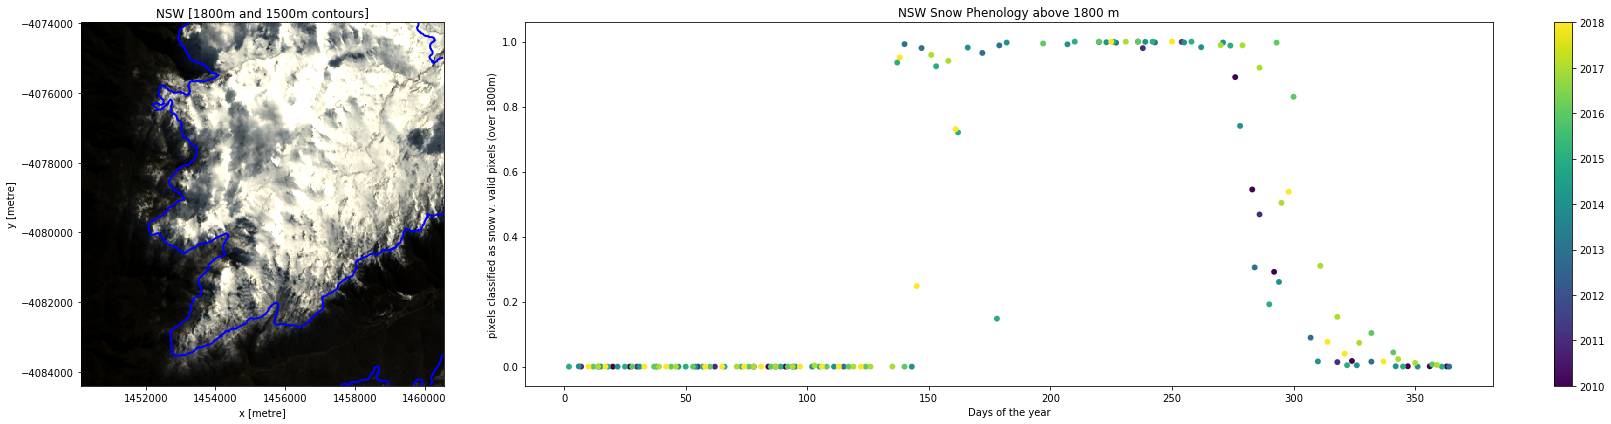

In [49]:
fig, axes = plt.subplots(ncols=2, 
                         figsize = (25, 6),
                        gridspec_kw={'width_ratios': [2, 5]})
a=landsat_ds[['red', 'green', 'blue']].isel(time=23).to_array().plot.imshow(ax=axes[0],robust=True)
#     a=contour_gdf_1800.plot(ax=axes[0], linewidth=k, color='mediumblue')
a=contour_gdf_1800.plot(linewidth=2, color='blue',ax=axes[0])
# a=contour_gdf_1500.plot(linewidth=2, color='firebrick')
a.title.set_text('NSW [1800m and 1500m contours]')
plt.tight_layout()

sp = plt.scatter(snow_df10s['dayofyear'], #ndsi_ds.values, 
                snow_df10s['snow_prop_elev'], c=snow_df10s['year'],
                cmap='viridis', marker='o', edgecolor='none',s=35)
#     plt.ylim(0,2)
plt.title('NSW Snow Phenology above 1800 m')
plt.xlabel('Days of the year')
plt.ylabel('pixels classified as snow v. valid pixels (over 1800m)')
fig.colorbar(sp)
# pdf.savefig()
# fig.save('2010s_nsw_phenology.png')


this can also be looked at for snow above other elevations:

In [50]:
# 1500 m elevation
contour_gdf_1500 = SpatialTools.contour_extract(z_values=1500, ds_array=elevation_2d, ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine, output_shp='extracted_contours_1500.shp')

c=list(range(len(snow_ds10s.time)))
snow_prop_elev10s_1500=[]
for i in c:
    d = valid_ds10s.isel(time=i).values * dem_elev1
    f = snow_ds10s.isel(time=i).values * dem_elev1
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev10s_1500.append(snow)
    
snow_df10s_1500 = pd.DataFrame({'dayofyear':snow_ds10s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev10s_1500, 'year':snow_ds10s['time.year']})

Operating in single array, multiple z-values mode
    Extracting contour 1500
Exporting contour shapefile to extracted_contours_1500.shp


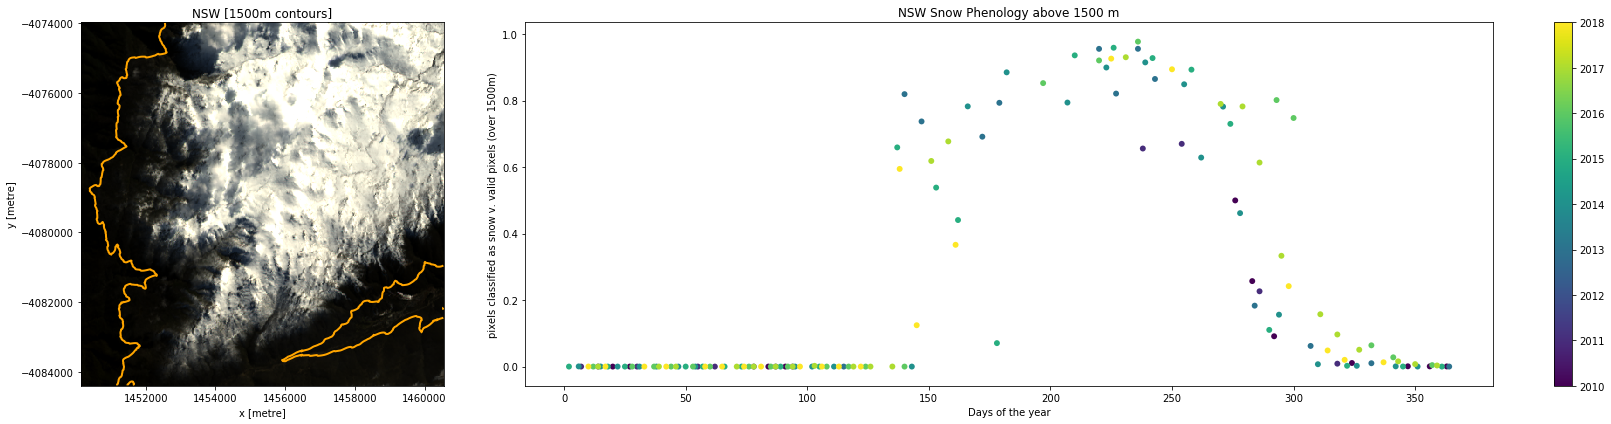

In [51]:
fig, axes = plt.subplots(ncols=2, 
                         figsize = (25, 6),
                        gridspec_kw={'width_ratios': [2, 5]})
a=landsat_ds[['red', 'green', 'blue']].isel(time=23).to_array().plot.imshow(ax=axes[0],robust=True)
a=contour_gdf_1500.plot(linewidth=2, color='orange',ax=axes[0])
a.title.set_text('NSW [1500m contours]')
plt.tight_layout()
sp = plt.scatter(snow_df10s_1500['dayofyear'], snow_df10s_1500['snow_prop_elev'], c=snow_df10s_1500['year'],
                cmap='viridis', marker='o', edgecolor='none',s=35)
plt.title('NSW Snow Phenology above 1500 m')
plt.xlabel('Days of the year')
plt.ylabel('pixels classified as snow v. valid pixels (over 1500m)')
fig.colorbar(sp)

Compare snow phenology to previous decades

In [52]:
time_range00s = ('2000-01-01', '2009-12-31')
time_range90s = ('1990-01-01', '1999-12-31')
time_range80s = ('1987-01-01', '1989-12-31')

In [53]:
query00s = {'x': (x - buffer_m, x + buffer_m), 'y': (y - buffer_n, y + buffer_n), 'time': time_range00s, 'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577', 'resolution': resolution}
query90s = {'x': (x - buffer_m, x + buffer_m), 'y': (y - buffer_n, y + buffer_n), 'time': time_range90s, 'crs': 'EPSG:3577',
            'output_crs': 'EPSG:3577', 'resolution': resolution}
query80s = {'x': (x - buffer_m, x + buffer_m), 'y': (y - buffer_n, y + buffer_n),  'time': time_range80s, 'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577', 'resolution': resolution}

In [54]:
landsat_ds00s = DEADataHandling.load_clearlandsat(dc=dc, product = 'nbar', query=query00s, mask_dict=snow_mask, sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop, mask_pixel_quality=True, ls7_slc_off=False)

Loading ls8
    Skipping ls8; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 90 filtered ls7 timesteps
Loading ls5
    Loading 140 filtered ls5 timesteps
Combining and sorting ls7, ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [55]:
landsat_ds90s = DEADataHandling.load_clearlandsat(dc=dc, product = 'nbar', query=query90s, mask_dict=snow_mask, sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop, mask_pixel_quality=True, ls7_slc_off=False)

Loading ls8
    Skipping ls8; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 9 filtered ls7 timesteps
Loading ls5
    Loading 219 filtered ls5 timesteps
Combining and sorting ls7, ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [56]:
landsat_ds80s = DEADataHandling.load_clearlandsat(dc=dc, product = 'nbar', query=query80s, mask_dict=snow_mask,
                                               sensors=['ls8', 'ls7', 'ls5'], bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop, mask_pixel_quality=True, ls7_slc_off=False)

Loading ls8
    Skipping ls8; no valid data for query
Loading ls7
    Skipping ls7; no valid data for query
Loading ls5
    Loading 44 filtered ls5 timesteps
Returning ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [57]:
valid_ds00s = np.isfinite(landsat_ds00s.swir1)
valid_ds90s = np.isfinite(landsat_ds90s.swir1)
valid_ds80s = np.isfinite(landsat_ds80s.swir1)


In [58]:
ndsi_ds00s = (landsat_ds00s.green -landsat_ds00s.swir1) / (landsat_ds00s.green + landsat_ds00s.swir1)
ndvi_ds00s = (landsat_ds00s.nir - landsat_ds00s.red) / (landsat_ds00s.nir + landsat_ds00s.red)

ndsi_ds90s = (landsat_ds90s.green - landsat_ds90s.swir1) / (landsat_ds90s.green + landsat_ds90s.swir1)
ndvi_ds90s = (landsat_ds90s.nir - landsat_ds90s.red) / (landsat_ds90s.nir + landsat_ds90s.red)

ndsi_ds80s = (landsat_ds80s.green - landsat_ds80s.swir1) / (landsat_ds80s.green + landsat_ds80s.swir1)
ndvi_ds80s = (landsat_ds80s.nir - landsat_ds80s.red) / (landsat_ds80s.nir + landsat_ds80s.red)

In [59]:
snow_ds0 = ndsi_ds00s > ndsi_threshold
noveg_ds00s = ndvi_ds00s < ndvi_threshold
red_ds00s = landsat_ds00s.red >1000
snow_ds00s = noveg_ds00s & snow_ds0 & red_ds00s

In [60]:
snow_ds9 = ndsi_ds90s > ndsi_threshold
noveg_ds90s = ndvi_ds90s < ndvi_threshold
red_ds90s = landsat_ds90s.red >1000
snow_ds90s = noveg_ds90s & snow_ds9 & red_ds90s


In [61]:
snow_ds8 = ndsi_ds80s > ndsi_threshold
noveg_ds80s = ndvi_ds80s < ndvi_threshold
red_ds80s = landsat_ds80s.red >1000
snow_ds80s = noveg_ds80s & snow_ds8 & red_ds80s


In [62]:
c=list(range(len(snow_ds00s.time)))
snow_prop_elev00s=[]
for i in c:
    d = valid_ds00s.isel(time=i).values * dem_elev
    f = snow_ds00s.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev00s.append(snow)
    
c=list(range(len(snow_ds00s.time)))
snow_prop_elev00s_1500=[]
for i in c:
    d = valid_ds00s.isel(time=i).values * dem_elev1
    f = snow_ds00s.isel(time=i).values * dem_elev1
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev00s_1500.append(snow)

In [63]:
c=list(range(len(snow_ds90s.time)))
snow_prop_elev90s=[]
for i in c:
    d = valid_ds90s.isel(time=i).values * dem_elev
    f = snow_ds90s.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev90s.append(snow)
    
    c=list(range(len(snow_ds90s.time)))
snow_prop_elev90s_1500=[]
for i in c:
    d = valid_ds90s.isel(time=i).values * dem_elev1
    f = snow_ds90s.isel(time=i).values * dem_elev1
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev90s_1500.append(snow)

In [64]:
c=list(range(len(snow_ds80s.time)))
snow_prop_elev80s=[]
for i in c:
    d = valid_ds80s.isel(time=i).values * dem_elev
    f = snow_ds80s.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev80s.append(snow)
    
c=list(range(len(snow_ds80s.time)))
snow_prop_elev80s_1500=[]
for i in c:
    d = valid_ds80s.isel(time=i).values * dem_elev1
    f = snow_ds80s.isel(time=i).values * dem_elev1
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev80s_1500.append(snow)

In [65]:
snow_df00s = pd.DataFrame({'dayofyear':snow_ds00s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev00s, 'year':snow_ds00s['time.year']})
snow_df00s_1500 = pd.DataFrame({'dayofyear':snow_ds00s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev00s_1500, 'year':snow_ds00s['time.year']})
snow_df90s = pd.DataFrame({'dayofyear':snow_ds90s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev90s, 'year':snow_ds90s['time.year']})
snow_df90s_1500 = pd.DataFrame({'dayofyear':snow_ds90s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev90s_1500, 'year':snow_ds90s['time.year']})
snow_df80s = pd.DataFrame({'dayofyear':snow_ds80s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev80s, 'year':snow_ds80s['time.year']})
snow_df80s_1500 = pd.DataFrame({'dayofyear':snow_ds80s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev80s_1500, 'year':snow_ds80s['time.year']})
# df.to_csv(output+years+'phenology_freq_'+str(elev)+'.csv')

all together, then mean of each decade plotted on one figure

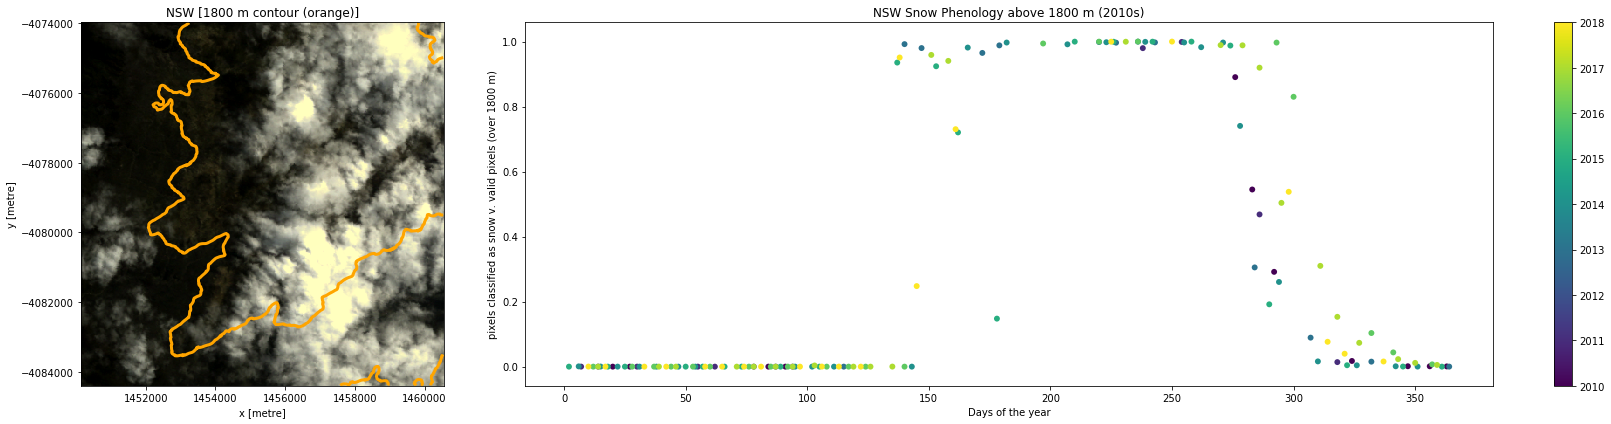

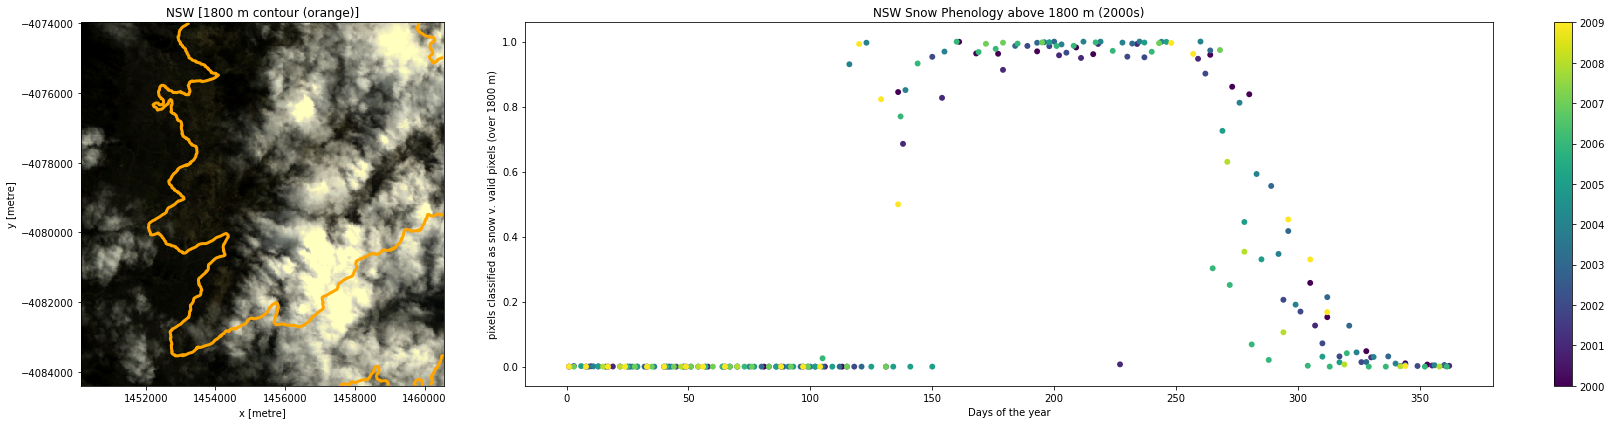

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_NSW_dem_snowf_v.pdf")

dfs=[
    (snow_df10s, 1800, 3, 0, 'orange', 2010), 
    (snow_df00s, 1800, 3, 0, 'orange', 2000),
    (snow_df90s, 1800, 3, 0, 'orange', 1990),
    (snow_df80s, 1800, 3, 0, 'orange', 1980),
    (snow_df10s_1500, 1500, 0, 3, 'red', 2010), 
    (snow_df00s_1500, 1500, 0, 3, 'red', 2000),
    (snow_df90s_1500, 1500, 0, 3, 'red', 1990),
    (snow_df80s_1500, 1500, 0, 3, 'red', 1980),
    ]

for i, j, k, l, m, n in dfs:
    fig, axes = plt.subplots(ncols=2, 
                             figsize = (25, 6),
                            gridspec_kw={'width_ratios': [2, 5]})

    a=landsat_ds[['red', 'green', 'blue']].isel(time=15).to_array().plot.imshow(ax=axes[0],robust=True)
#     a=contour_gdf_1800.plot(ax=axes[0], linewidth=k, color='mediumblue')
    a=contour_gdf_1800.plot(ax=axes[0], linewidth=k, color='orange')
    a=contour_gdf_1500.plot(ax=axes[0], linewidth=l, color='firebrick')
    a.title.set_text('NSW ['+str(j)+' m contour ('+str(m)+')]')
    plt.tight_layout()

    sp = plt.scatter(i['dayofyear'], #ndsi_ds.values, 
                    i['snow_prop_elev'], c=i['year'],
                    cmap='viridis', marker='o', edgecolor='none',s=35)
#     plt.ylim(0,2)
    plt.title('NSW Snow Phenology above '+str(j)+' m ('+str(n)+'s)')
    plt.xlabel('Days of the year')
    plt.ylabel('pixels classified as snow v. valid pixels (over '+str(j)+' m)')
    fig.colorbar(sp)
    pdf.savefig()
    
    
# fig, ax = plt.subplots(figsize=(16,5))   
# a=snow_df10s.set_index('dayofyear')
# b=a.sort_index(ascending=True)
# b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3)

# a=snow_df00s.set_index('dayofyear')
# b=a.sort_index(ascending=True)
# b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3)

# a=snow_df90s.set_index('dayofyear')
# b=a.sort_index(ascending=True)
# b.rolling(25).median().plot(y='snow_prop_elev',ax=ax, linewidth=3)

# plt.title('NSW Snow Phenology above 1800 m')
# plt.xlabel('Days of the year')
# plt.ylabel('pixels classified as snow v. valid pixels (over 1800 m)')
# plt.legend(['2010s', '2000s', '1990s'])
# pdf.savefig()

# fig, ax = plt.subplots(figsize=(16,5))
# a=snow_df10s_1500.set_index('dayofyear')
# b=a.sort_index(ascending=True)
# b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3, color='purple')

# a=snow_df00s_1500.set_index('dayofyear')
# b=a.sort_index(ascending=True)
# b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3, color='green')

# a=snow_df90s_1500.set_index('dayofyear')
# b=a.sort_index(ascending=True)
# b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3, color='pink')

# plt.title('NSW Snow Phenology above 1500 m')
# plt.xlabel('Days of the year')
# plt.ylabel('pixels classified as snow v. valid pixels (over 1500 m)')
# plt.legend(['2010s', '2000s', '1990s'])
# # fig.colorbar(sp)
# pdf.savefig()
pdf.close()

Compare phenology against previuos decades
(include mean)

In [ ]:
time_range00s = ('2000-01-01', '2009-12-31')
time_range90s = ('1990-01-01', '1999-12-31')
time_range80s = ('1987-01-01', '1989-12-31')

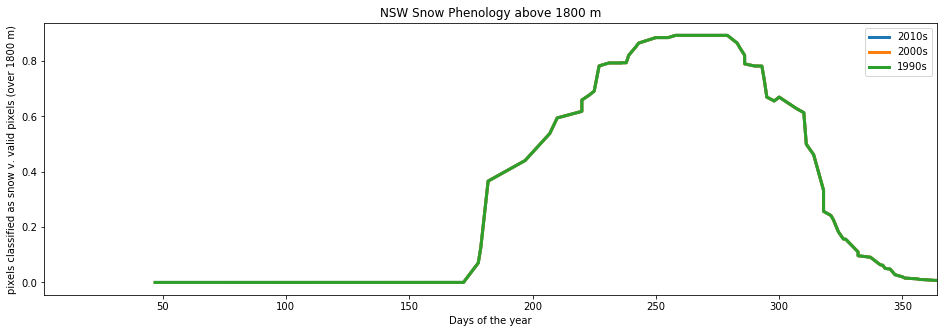

In [104]:
    
    
pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_NSW_dem_snowf_v.pdf")

dfs=[
    (snow_df10s, 1800, 3, 0, 'orange', 2010), 
    (snow_df00s, 1800, 3, 0, 'orange', 2000),
    (snow_df90s, 1800, 3, 0, 'orange', 1990),
    (snow_df80s, 1800, 3, 0, 'orange', 1980),
    (snow_df10s_1500, 1500, 0, 3, 'red', 2010), 
    (snow_df00s_1500, 1500, 0, 3, 'red', 2000),
    (snow_df90s_1500, 1500, 0, 3, 'red', 1990),
    (snow_df80s_1500, 1500, 0, 3, 'red', 1980),
    ]

fig, ax = plt.subplots(figsize=(16,5))   
a=snow_df10s.set_index('dayofyear')
b=a.sort_index(ascending=True)
b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3)

a=snow_df00s.set_index('dayofyear')
b=a.sort_index(ascending=True)
b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3)

a=snow_df90s.set_index('dayofyear')
b=a.sort_index(ascending=True)
b.rolling(25).median().plot(y='snow_prop_elev',ax=ax, linewidth=3)

plt.title('NSW Snow Phenology above 1800 m')
plt.xlabel('Days of the year')
plt.ylabel('pixels classified as snow v. valid pixels (over 1800 m)')
plt.legend(['2010s', '2000s', '1990s'])
pdf.savefig()

fig, ax = plt.subplots(figsize=(16,5))
a=snow_df10s_1500.set_index('dayofyear')
b=a.sort_index(ascending=True)
b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3, color='purple')

a=snow_df00s_1500.set_index('dayofyear')
b=a.sort_index(ascending=True)
b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3, color='green')

a=snow_df90s_1500.set_index('dayofyear')
b=a.sort_index(ascending=True)
b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3, color='pink')

plt.title('NSW Snow Phenology above 1500 m')
plt.xlabel('Days of the year')
plt.ylabel('pixels classified as snow v. valid pixels (over 1500 m)')
plt.legend(['2010s', '2000s', '1990s'])
fig.colorbar(sp)
pdf.savefig()
pdf.close()

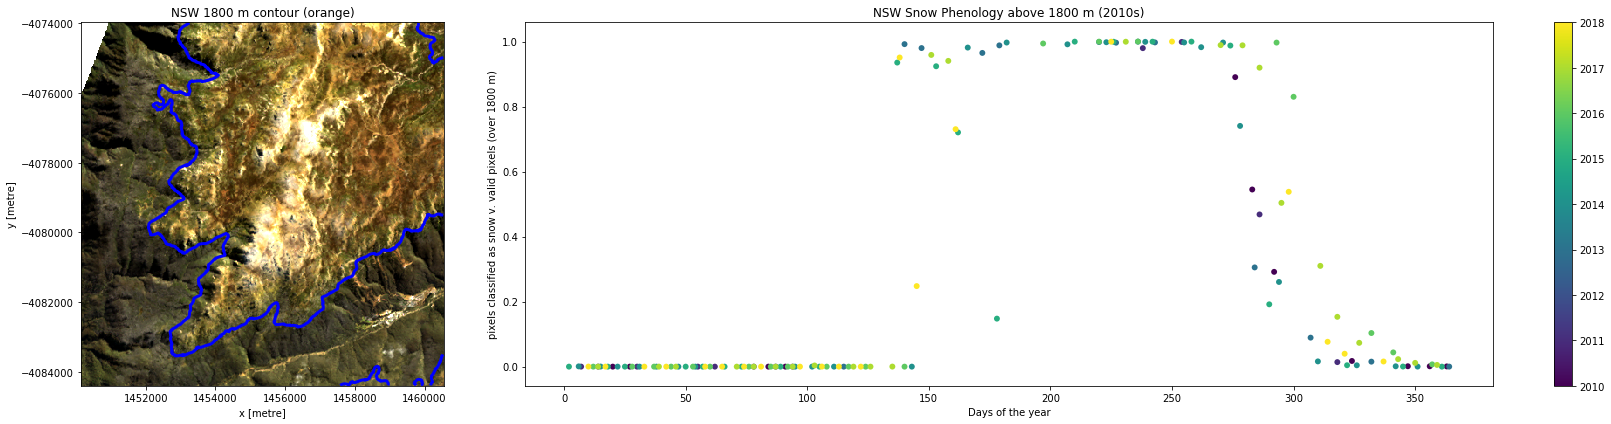

In [43]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("tas_phen_10s.pdf")

# dfs=[
#     (snow_df10s, 1500, 3, 0, 'orange'), 
#     (Snow_phen1200, 1200, 0, 3, 'red')
#     ]
# for i, j, k, l, m in dfs:
fig, axes = plt.subplots(ncols=2, 
                         figsize = (25, 6),
                        gridspec_kw={'width_ratios': [2, 5]})

a=landsat_ds[['red', 'green', 'blue']].isel(time=10).to_array().plot.imshow(ax=axes[0],robust=True)
#     a=contour_gdf_1800.plot(ax=axes[0], linewidth=k, color='mediumblue')
a=contour_gdf_1800.plot(ax=axes[0], linewidth=3, color='blue')
# a=contour_gdf_1200.plot(ax=axes[0], linewidth=l, color='firebrick')
a.title.set_text('NSW 1800 m contour (orange)')
plt.tight_layout()

sp = plt.scatter(snow_df10s['dayofyear'], #ndsi_ds.values, 
                snow_df10s['snow_prop_elev'], c=snow_df10s['year'],
                cmap='viridis', marker='o', edgecolor='none',s=35)
#     plt.ylim(0,2)
plt.title('NSW Snow Phenology above 1800 m (2010s)')
plt.xlabel('Days of the year')
plt.ylabel('pixels classified as snow v. valid pixels (over 1800 m)')
fig.colorbar(sp)
pdf.savefig()

In [82]:
snow_df10 = pd.DataFrame({'dayofyear':snow_ds10['time.dayofyear'], 'snow_prop_elev':snow_prop_elev10, 'year':snow_ds10['time.year']})
# df.to_csv(output+years+'phenology_freq_'+str(elev)+'.csv')

In [91]:
snow_df11 = pd.DataFrame({'dayofyear':snow_ds10['time.dayofyear'], 'snow_prop_elev':snow_prop_elev11, 'year':snow_ds10['time.year']})

In [64]:
elevation_query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         #'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 
elevation_data = dc.load(product='srtm_dem1sv1_0', **elevation_query)
# elevation_data.dem.plot(figsize=(8,10),cmap='terrain')
elevation_2d = elevation_data.dem_h.squeeze('time')

In [92]:
contour_gdf_1800 = SpatialTools.contour_extract(z_values=1800,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_contours_1800.shp')
contour_gdf_1500 = SpatialTools.contour_extract(z_values=1500,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_contours_1800.shp')

Operating in single array, multiple z-values mode
    Extracting contour 1800
Exporting contour shapefile to extracted_contours_1800.shp
Operating in single array, multiple z-values mode
    Extracting contour 1500
Exporting contour shapefile to extracted_contours_1800.shp


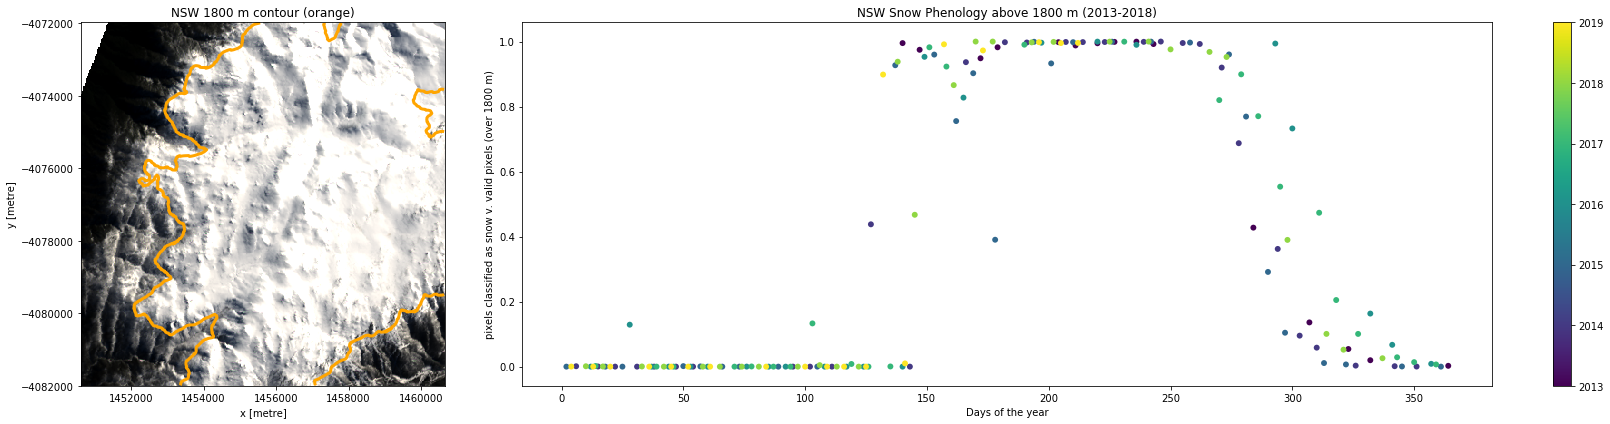

In [84]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("small_area_phen2013_2018.pdf")

# dfs=[
#     (Snow_phen1500, 1500, 3, 0, 'orange'), 
#     (Snow_phen1200, 1200, 0, 3, 'red')
#     ]
# for i, j, k, l, m in dfs:
fig, axes = plt.subplots(ncols=2, 
                         figsize = (25, 6),
                        gridspec_kw={'width_ratios': [2, 5]})

a=landsat_ds2[['red', 'green', 'blue']].isel(time=20).to_array().plot.imshow(ax=axes[0],robust=True)
#     a=contour_gdf_1800.plot(ax=axes[0], linewidth=k, color='mediumblue')
a=contour_gdf_1800.plot(ax=axes[0], linewidth=3, color='orange')
# a=contour_gdf_1200.plot(ax=axes[0], linewidth=l, color='firebrick')
a.title.set_text('NSW 1800 m contour (orange)')
plt.tight_layout()

sp = plt.scatter(snow_df10['dayofyear'], #ndsi_ds.values, 
                snow_df10['snow_prop_elev'], c=snow_df10['year'],
                cmap='viridis', marker='o', edgecolor='none',s=35)
#     plt.ylim(0,2)
plt.title('NSW Snow Phenology above 1800 m (2013-2018)')
plt.xlabel('Days of the year')
plt.ylabel('pixels classified as snow v. valid pixels (over 1800 m)')
fig.colorbar(sp)
pdf.savefig()

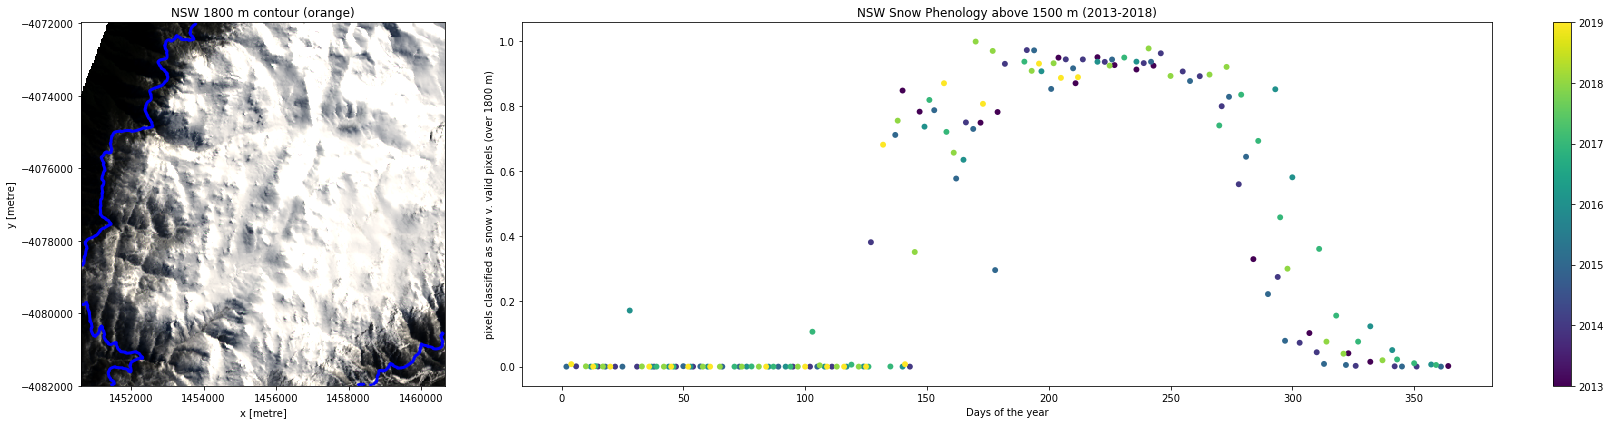

In [96]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("small_area1500_phen2013_2018.pdf")

# dfs=[
#     (Snow_phen1500, 1500, 3, 0, 'orange'), 
#     (Snow_phen1200, 1200, 0, 3, 'red')
#     ]
# for i, j, k, l, m in dfs:
fig, axes = plt.subplots(ncols=2, 
                         figsize = (25, 6),
                        gridspec_kw={'width_ratios': [2, 5]})

a=landsat_ds2[['red', 'green', 'blue']].isel(time=20).to_array().plot.imshow(ax=axes[0],robust=True)
#     a=contour_gdf_1800.plot(ax=axes[0], linewidth=k, color='mediumblue')
a=contour_gdf_1500.plot(ax=axes[0], linewidth=3, color='blue')
# a=contour_gdf_1200.plot(ax=axes[0], linewidth=l, color='firebrick')
a.title.set_text('NSW 1800 m contour (orange)')
plt.tight_layout()

sp = plt.scatter(snow_df11['dayofyear'], #ndsi_ds.values, 
                snow_df11['snow_prop_elev'], c=snow_df11['year'],
                cmap='viridis', marker='o', edgecolor='none',s=35)
#     plt.ylim(0,2)
plt.title('NSW Snow Phenology above 1500 m (2013-2018)')
plt.xlabel('Days of the year')
plt.ylabel('pixels classified as snow v. valid pixels (over 1800 m)')
fig.colorbar(sp)
pdf.savefig()

In [ ]:
# comparing decades
# minimum script required to produce above image - and produce for 90s, 00s
# then rolling means to compare decades



In [220]:
# lat, lon, buffer_m, buffer_n = -36.3, 148.35, 35000, 45000
lat, lon, buffer_m, buffer_n = -36.3, 148.35, 30000, 40000
# lat1, lon1, buffer_m1, = -36.86895, 147.276, 10000, #10000 #vic

# lat1, lon1, buffer_m1 = -36.435, 148.29, 8000
# Set range of time to return data from both Landsat and Sentinel 2
time_range = ('2017-10-01', '2017-10-17')
resolution = (-25, 25)
landsat_goodquality_prop = 0.10

ndsi_threshold = 0.0
ndvi_threshold = 0.3

ndwi_threshold = 0.15

x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query1 = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

In [221]:
snow_mask = dict(                cloud_acca='no_cloud',
                                 #cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 #cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)

landsat_ds5 = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query1,
                                               mask_dict=snow_mask,
                                               sensors=['ls5','ls7','ls8'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=True)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 2 filtered ls7 timesteps
Loading ls8
    Loading 2 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [223]:
landsat_ds6 = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query1,
                                               #mask_dict=snow_mask,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False,
                                               ls7_slc_off=True)

Loading ls8
    Loading 2 filtered ls8 timesteps
Loading ls7
    Loading 2 filtered ls7 timesteps
Loading ls5
    Skipping ls5; no valid data for query
Combining and sorting ls8, ls7 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [222]:
ndsi_ds = (landsat_ds5.green - landsat_ds5.swir1) / (landsat_ds5.green + landsat_ds5.swir1)
ndvi_ds = (landsat_ds5.nir - landsat_ds5.red) / (landsat_ds5.nir + landsat_ds5.red)
ndwi_ds = (landsat_ds5.green - landsat_ds5.nir)/(landsat_ds5.green + landsat_ds5.nir)

In [197]:
# ndwi_ds.isel(time=2).plot(cmap='Blues', figsize=(8,8))

In [209]:
snow_ds1 = ndsi_ds > ndsi_threshold
noveg_ds = ndvi_ds < ndvi_threshold
# nowater_ds = ndwi_ds < ndwi_threshold
# snow_ds2 = noveg_ds & snow_ds & red #&nowater_ds
snow_ds = noveg_ds & snow_ds1# &nowater_ds

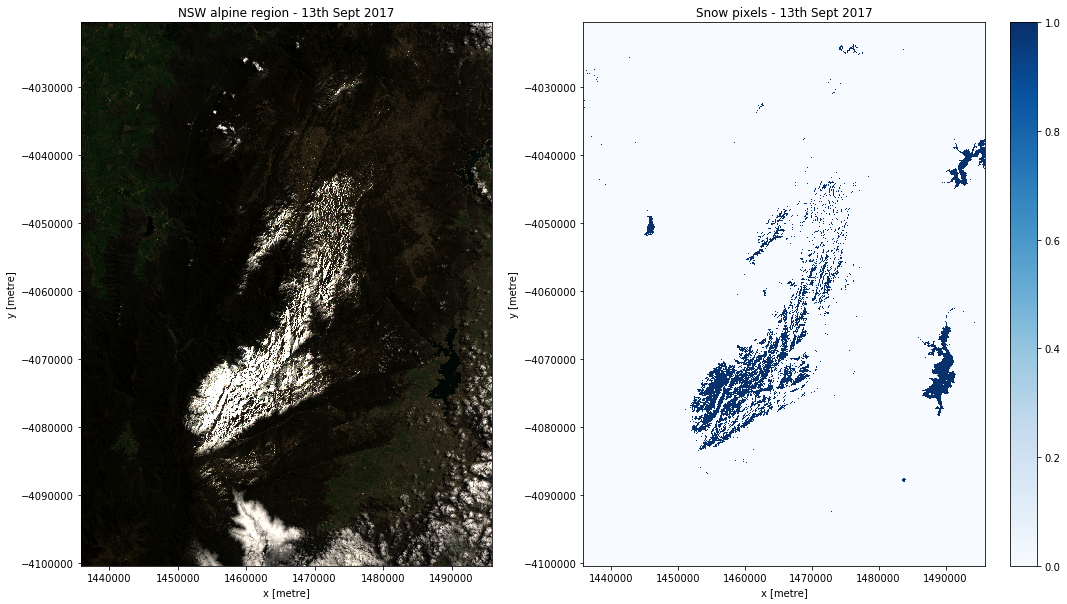

In [226]:
fig, axes = plt.subplots(ncols=2, 
                         figsize = (18, 10),
                        gridspec_kw={'width_ratios': [9,11]}
                        )
i=2

a=landsat_ds6[['red', 'green', 'blue']].isel(time=i).to_array().plot.imshow(robust=True, ax=axes[0])
b=snow_ds.isel(time=i).plot(ax=axes[1], cmap='Blues')
axes[0].set_title('NSW alpine region - 13th Sept 2017')
axes[1].set_title('Snow pixels - 13th Sept 2017')
# axes[2].set_title('NDVI - 31th May 2017')
# a.set_clim(-1,1)
b.set_clim(0, 1)
plt.savefig('nsw_snow_pixels.png')

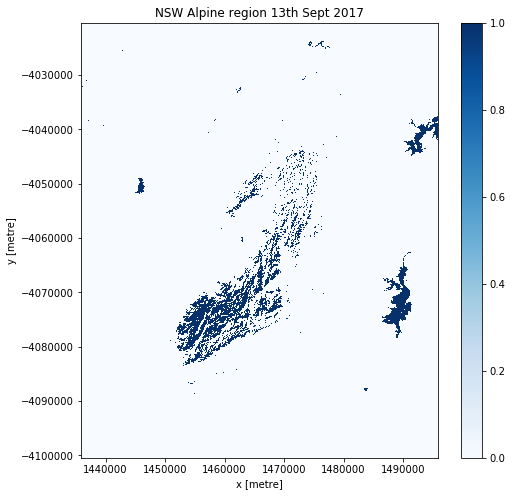

In [227]:
snow_ds.isel(time=2).plot(cmap='Blues', figsize=(8,8))
# plt.title
plt.title('NSW Alpine region 13th Sept 2017')
plt.savefig('nsw_snow_pixels1.png')

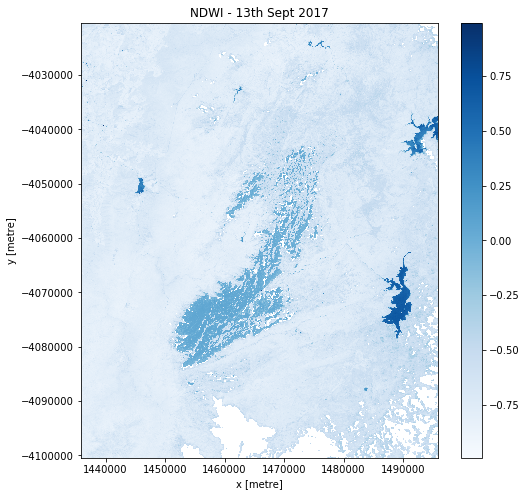

In [228]:
ndwi_ds.isel(time=2).plot(cmap='Blues', figsize=(8,8))
plt.title('NDWI - 13th Sept 2017')
plt.savefig('nsw_ndwi.png')

Text(0.5, 1.0, 'Red band - 13th Sept 2017')

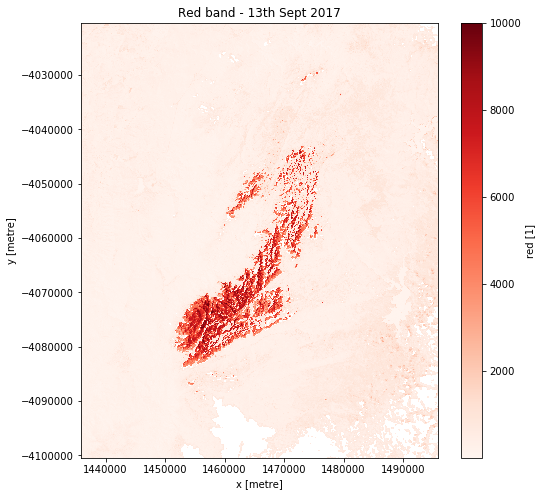

In [243]:
landsat_ds5.red.isel(time=i).plot(cmap='Reds', figsize=(8,8))
plt.title('Red band - 13th Sept 2017')
# plt.savefig('nsw_red.png')

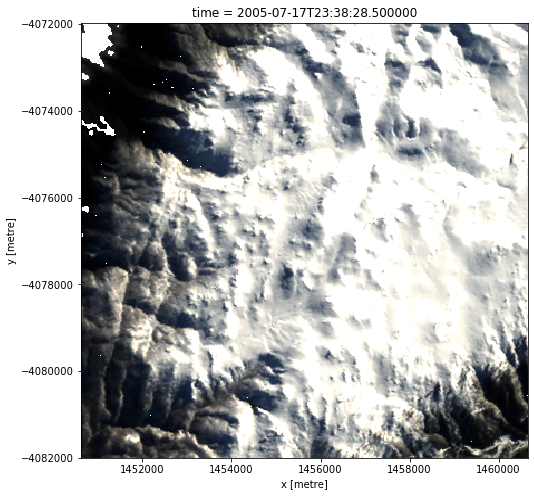

In [89]:
landsat_ds1[['red', 'green', 'blue']].isel(time=165).to_array().plot.imshow(robust=True, figsize=(8, 8))

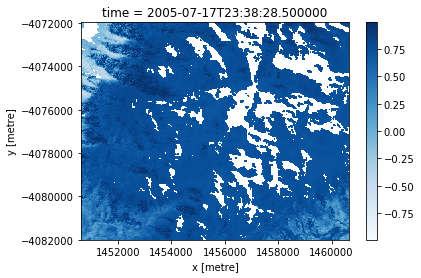

In [88]:
ndsi_ds1.isel(time=165).plot(cmap='Blues')

In [67]:
# define snow/no-snow

snow_ds1 = ndsi_ds > ndsi_threshold
noveg_ds = ndvi_ds < ndvi_threshold
nowater_ds = ndwi_ds < ndwi_threshold
snow_ds = noveg_ds & snow_ds1 & nowater_ds

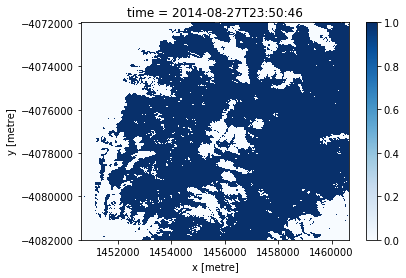

In [69]:
snow_ds.isel(time=135).plot(cmap='Blues')

In [70]:
# decadal plots, normalised sum of all images
red_threshold = 1000
red_ds = landsat_ds.red > red_threshold
snow_ds = noveg_ds & snow_ds1 & nowater_ds & red_ds

In [71]:
# different decades in a loop?

snow_sum = snow_ds.sum(dim='time')
valid_sum = valid_ds.sum(dim='time')
snow_prop = (snow_sum / valid_sum)

# # snow_prop.plot()
# # plt.savefig('decade_example.png')


# snow_sum1=snow_sum.squeeze()

# transform, projection = SpatialTools.geotransform(snow_sum1, (snow_sum1.x, snow_sum1.y), epsg=3577)
# SpatialTools.array_to_geotiff(output+year+'snow.tif',
#               snow_sum1.values, geo_transform = transform, 
#               projection = projection, 
#               nodata_val=np.nan)

# valid_sum1=valid_sum.squeeze()

# transform, projection = SpatialTools.geotransform(valid_sum1, (valid_sum1.x, valid_sum1.y), epsg=3577)
# SpatialTools.array_to_geotiff(output+year+'valid.tif',
#               valid_sum1.values, geo_transform = transform, 
#               projection = projection, 
#               nodata_val=np.nan)

Text(0.5, 1.0, 'NSW alpine region 10s')

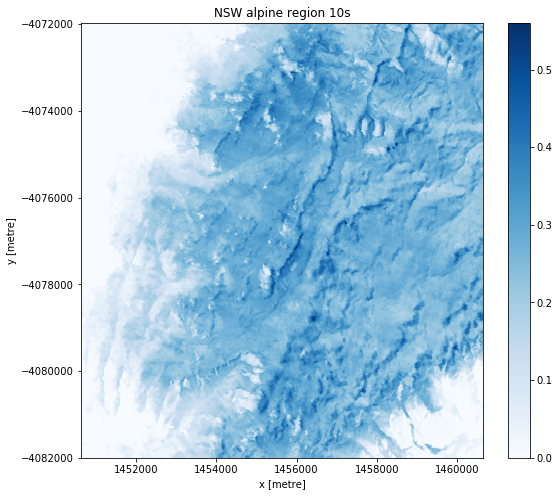

In [72]:
snow_prop.plot(figsize=(9, 8), cmap='Blues')
plt.title('NSW alpine region 10s')

In [ ]:

# snow phenology above a specific elevation
# includes creating contours



# importing a dem for the region

x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query1 = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         #'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

# Load the DEM data
dem_ds = dc.load(product='srtm_dem1sv1_0', **query1)
dem_elev = dem_ds.dem > elev

# snow_elev = snow_ds.where(dem_elev.squeeze(dim='time'))
# valid_elev = valid_ds.where(dem_elev.squeeze(dim='time'))
# snow_prop = snow_elev/valid_elev

c=list(range(len(snow_ds.time)))
snow_prop_elev=[]
for i in c:
    d = valid_ds.isel(time=i).values * dem_elev
    f = snow_ds.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev.append(snow)
    
    

# mask ndsi dataset with dem_1800, leaving values over 1800 m
# ndsi_elev = ndsi_ds.where(dem_elev.squeeze(dim='time'))
# calculate ndsi mean of valid pixels over 1800 m 
# mean_ndsi_elev = ndsi_elev.mean(dim=('x', 'y'))


# df = pd.DataFrame({'time':snow_ds.time, 'snow_prop_1800':snow_prop_1800, 'pixel_prop':prop_, 'pixel_over_005':prop_rel})
# df.to_csv(output+years+'NEWmask_frequency_prop.csv')

# df = pd.DataFrame({'dayofyear':snow_ds['time.dayofyear'], 'proportion':snow_ds.values, 'year':ndsi_ds['time.year']})
# df.to_csv(output+years+'phenology_freq_1800.csv')

df = pd.DataFrame({'dayofyear':snow_ds['time.dayofyear'], 'snow_prop_elev':snow_prop_elev, 'year':snow_ds['time.year']})
df.to_csv(output+years+'phenology_freq_'+str(elev)+'.csv')